## Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기

ResNet 의 성능을 평가하기 위해서 원래 논문과 동일한 이미지넷의 훈련과 검증 데이터셋을 사용하면 평가와 학습에 더 좋겠지만! 컴퓨팅 자원이 부족하니까 이미지넷보다는 적당한 크기의 CIFAR-10 데이터셋으로 평가할 것이다.

#### 우리의 실험 : CIFAR-10 에 대해서 일반 네트워크와 ResNet 을 구현해서 이 둘을 비교해서 ResNet 및 residual connection 의 유효성을 확인하는 것이다!

### 1) CIFAR-10

<준비물>      
텐서플로우에서 제공하는 tensorflow-datasets 패키지가 설치되어 있지 않다면 명령어로 설치!       
- $ pip install tensorflow-datasets

In [1]:
## 필요한 라이브러리 import

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print("뿅!")

뿅!


In [2]:
## GPU 가 있는지 확인해보는거

# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터 불러오기

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.
## tfds를 보면 아주 유용하게 사용이 가능하다.
## split 을 할 때 train : 80% , 뭐 이렇게 나눠서도 할 수 있음
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    ## shuffle_files 가 True니까 file 을 shuffle 해준다.
    ## 모르면 tfds.load() 에서 shuffle_files를 검색하면 더 찾아보면 된다.
    shuffle_files=True,
    ## info 가  참이라서 ds_info를 가져올 수 있구나!
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


데이터에 대한 정보 확인~ ( 데이터에 대한 확인이 구체적이면 더 좋을 거 같다)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
## features 라는거를 ds_info로 가져온다? 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


결과 값을 보면 key 값 value 를 알 수 있고 Dict라고 되어있으니까 딕셔너리

In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [6]:
ds_info.features["label"].num_classes

10

In [7]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

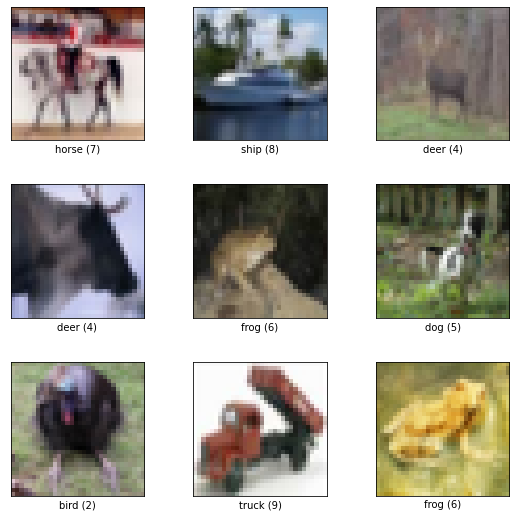

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

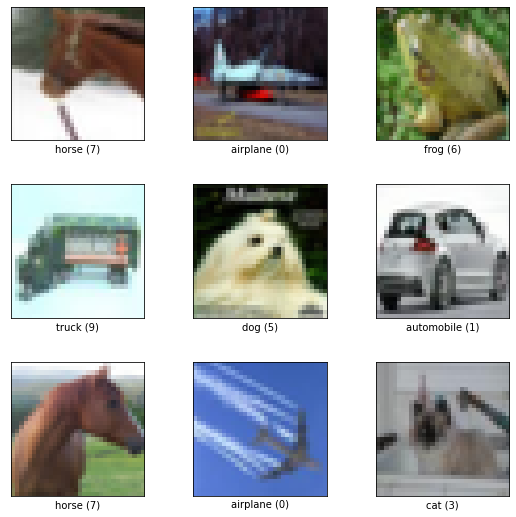

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

## 2. 데이터 전처리

### 2) Input Normalization

In [10]:
## 이름을 보고 뭐하는지 알고 난 다음에! image랑 label을 가지고!
## 그리고 2개를 반환한다.
## tf.cast 를 보면 변환하는거? 그래서 변환해서 2개의 이미지를 반환한다.

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [11]:
## type(ds_train)

In [12]:
## normalize 를 직접 시도??

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ## ds 는 dataset 을 의미한다.
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 모델 설계

## (2) 블록 구성하기

일반적인 딥러닝 모델에서 주요 구조를 모듈화 시켜서 조금씩 바꿔 쓸 수 있는 단위를 블록(block) 이라고 부른다. 레이어(layer)는 기본적으로 텐서플로우, 케라스, 파이토치 등에서 기본적으로 제공하는 단위이다.      
** 한 단계 위인 "블록(block)" 을 단위로 모델을 만들 수 있어야 한다. **

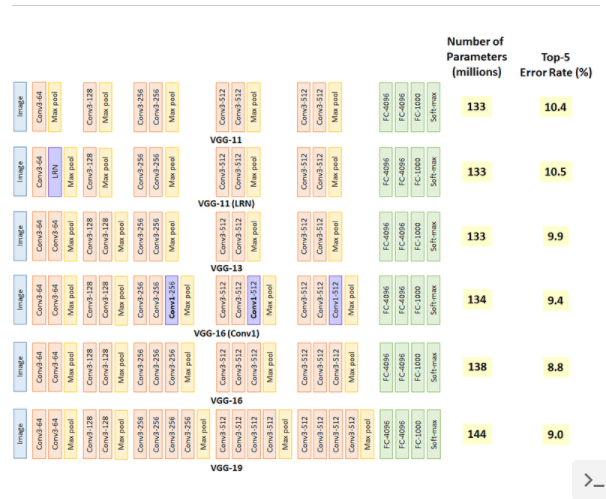

In [13]:
from IPython.display import Image
Image(filename='1.png')

VGG 는 합성곱 계층과 풀링 계층으로 구성되는 기본적인 CNN 이다.    
다만, 비중이 있는 층 (합성곱 계층, 완전연결 계층) 을 모두 16층 (19층) 으로 심화한 게 특징이다.     
- 층의 깊이에 따라서 'VGG16' 과 'VGG19' 로 구분되어진다.

### VGG 기본 블록 만들기

In [14]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [15]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [16]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


## (3) VGG Complete Model

기본적인 블록을 만들 수 있는 함수를 만들었으니까! 이를 합쳐서 전체 모델을 만들 수 있는 함수를 만들어보자!

### 1) VGG-16

In [17]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [18]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
## (이게 모델) 
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### 2) VGG-19

In [19]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## 모델 학습

## (4) VGG-16 vs VGG-19

In [20]:
## 한 번에 데이터를 몇 개 볼 것인가? 
## 몇 번 볼 것인가?
BATCH_SIZE = 256
EPOCH = 15

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

❗잠깐

이 작업은 시간이 상당히 소요됩니다. BATCH_SIZE가 커지면 소요시간이 좀 줄어드는 효과가 있습니다만, 1epoch당 1분 이상 소요될 수도 있습니다. 이 훈련은 40Epoch 정도 수행하는 것을 권장하지만, 15Epoch 정도로도 어느 정도 근접하는 성능을 얻을 수는 있을 것입니다.



In [22]:
## compile 은 학습을 어떻게 시킬지에 대한 것
## loss를 정의하는 것과 굉장히 근접하다.
## loss를 작게하는 방법으로 모델을 학습? 
## optimizer에 따라서 학습을 어떻게 시킬지에 대해 영향을 준다.
## object detection
## metrics 이 accuracy? 


vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
## fit 은 모델을 학습을 시키는 코드
history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


195/195 [==============================] - 66s 127ms/step - loss: 2.2048 - accuracy: 0.1781 - val_loss: 2.0973 - val_accuracy: 0.2441
Epoch 2/15
195/195 [==============================] - 22s 114ms/step - loss: 2.0148 - accuracy: 0.2639 - val_loss: 1.9264 - val_accuracy: 0.3058
Epoch 3/15
195/195 [==============================] - 22s 115ms/step - loss: 1.8867 - accuracy: 0.3210 - val_loss: 1.8402 - val_accuracy: 0.3336
Epoch 4/15
195/195 [==============================] - 23s 117ms/step - loss: 1.7745 - accuracy: 0.3633 - val_loss: 1.6882 - val_accuracy: 0.3897
Epoch 5/15
195/195 [==============================] - 23s 117ms/step - loss: 1.6796 - accuracy: 0.3959 - val_loss: 1.6634 - val_accuracy: 0.3976
Epoch 6/15
195/195 [==============================] - 23s 119ms/step - loss: 1.6155 - accuracy: 0.4178 - val_loss: 1.6072 - val_accuracy: 0.4325
Epoch 7/15
195/195 [==============================] - 23s 120ms/step - loss: 1.5640 - accuracy: 0.4385 - val_loss: 1.5529 - val_accuracy: 0.4

VGG-19 모델을 만들고 훈련시켜 줍니다.

파라미터가 더 많은 VGG-19는 VGG-16보다 1/4 정도 훈련 시간이 더 걸립니다. Epoch 수나 BATCH_SIZE를 잘 조절해 주세요.

In [23]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 33s 145ms/step - loss: 2.2292 - accuracy: 0.1624 - val_loss: 2.1333 - val_accuracy: 0.2352
Epoch 2/15
195/195 [==============================] - 28s 146ms/step - loss: 2.0536 - accuracy: 0.2451 - val_loss: 2.0131 - val_accuracy: 0.2630
Epoch 3/15
195/195 [==============================] - 28s 145ms/step - loss: 1.9146 - accuracy: 0.3023 - val_loss: 1.8406 - val_accuracy: 0.3336
Epoch 4/15
195/195 [==============================] - 28s 145ms/step - loss: 1.7916 - accuracy: 0.3479 - val_loss: 1.7618 - val_accuracy: 0.3795
Epoch 5/15
195/195 [==============================] - 28s 146ms/step - loss: 1.7013 - accuracy: 0.3811 - val_loss: 1.6949 - val_accuracy: 0.3811
Epoch 6/15
195/195 [==============================] - 28s 145ms/step - loss: 1.6345 - accuracy: 0.4120 - val_loss: 1.5880 - val_accuracy: 0.4257
Epoch 7/15
195/195 [==============================] - 28s 146ms/step - loss: 1.5887 - accuracy: 0.4233 - val_loss: 1.5452 - val_ac

모델 평가가 아니라 학습에 넣는게 맞다라고 생각한다. 왜냐면 모델 평가는 test데이터로 해야한다고 생각?      
- train 은 모델을 학습   
- validation 은 모델이 잘 학습이 되고 있는지 확인? 모니터링?     
    - tf 의 EarlyStopping은 validation 을 가지고 멈춘다.       
    - 이런거를 보면 학습에 val_loss가 관여를 한다.      
- test는 모델을 평가?       
    - 이게 모델 평가에 영향을 주는거     
    - 우리가 일상생활에 사용하는 그런 데이터로 확인을 해서 모델을 평가함

이제 VGG-16과 VGG-19를 그래프를 그리고 비교해보도록 하겠습니다. 먼저 훈련 손실(training loss)이 어떻게 다르게 진행되는지 비교해봅시다.

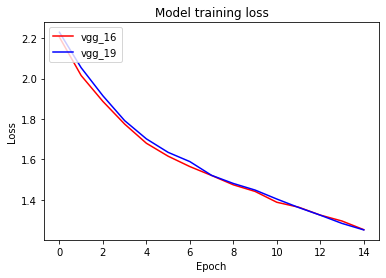

In [24]:
## 학습 된 결과를 확인하는거
## history 라는게 학습의 결과물? 그래서 결론적으로는 모델을 평가 하는게 아니라
## 우리가 학습시킨 결과물을 2개를 비교하는 요런느낌?

import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

그리고 검증 정확도(validation accuracy)를 비교해 봅시다.

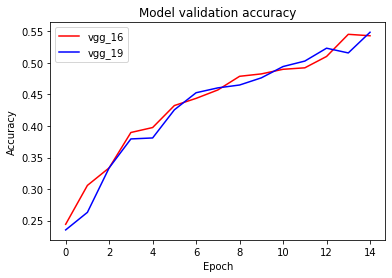

In [25]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

In [26]:
## 모델 평가    
## modle.evaluate(ds_test)?